# Visual Similarity using [MILDNet](https://arxiv.org/abs/1903.00905) and [RankNet](https://arxiv.org/abs/1901.03546)
Anirudha Vishvakarma (anirudhav@gofynd.com)

The work presented here is done at Fynd while researching for a better way to retrieve visual similar images from the entire catalog dataset. Two research paper came out of it with new architectures:
- [MILDNet](https://arxiv.org/abs/1903.00905): Single scale triplet based architecture, around 3 times lighter and as accurate as current state-of-the-art models.
- [RankNet](https://arxiv.org/abs/1901.03546): Multi-scale triplet based architecture, used Siamese network and contrastive loss to outperform the current state-of-the-art models.

Detailed technical detail is presented in our papers published on Arxiv. This colab notebook uses code open sourced [here](https://github.com/sudoawesomeness/mildnet) on github.

This content is licensed under an [APL 2.0 License](https://github.com/pkmital/CycleGAN/blob/master/LICENSE).

# Concepts

## Introduction

Visual Recommendation is a crucial feature for any ecommerce platform. It gives the platform power of instantly suggesting similar looking products to what a user is browsing, thus capturing his/her immediate intent which could result in higher customer engagment (CTR) and hence the conversion.

The task of identifying similar products is not trivial as the details concerned here (pattern, structure etc.) are complexely grained in the product image pixels and these product comes in various variety even within the same class. CNNs have showed great understanding and results in this task.

The base of such a system is a CNN extracting key features from product images and returning a vector respresenting those features. When these embeddings for all the products are mapped on an n-dimensional space, it places similar products closer to non-similar items. The nearest neighbours are then the top most visual similar items. Below diagram gives a brief overview:

<p align="center">
  <img width="100%" src="https://storage.googleapis.com/ml_shared_bucket/MILDNet/doc_imgs/VS_Basic_Inference_Flow.jpg">
</p>

## Training Data

Triplet data is generally used which consists of a query image, positive image (similar to query image) and a negative image (relatively dissimilar to query image as positive image).  The query image can either be
- Wild Image: where people wearing the cloth in everyday uncontrolled settings.
- Catalog Image: model wearing cloth in controlled settings as shown in an ecommerce app.

While the positive and negative images can also be
- In-class: same product category as query image
- Out-of-class: other product category than query image

Below diagram shows samples of triplet sets:

<p align="center">
  <img width="40%" src="https://storage.googleapis.com/ml_shared_bucket/MILDNet/doc_imgs/Database_Sample.png">
</p>

## Architectures

Various models are studied in this reseach work. The basic architectures are explained in this section.
- **Multi-scale deep ranking architecture**:  Multi-scale network architecture consists of 3 independent CNNs: 1. Convnet(AlexNet/VGG16/VGG19) pretrained on ImageNet dataset 2. Shallow Network 3. Shallow network. The convnet captures the image semantics while shallow networks focus on the visual appearance. Embeddings from them are passed to a fully connected layer to get 4096-d embeddings.

<p align="center">
  <img width="50%" src="https://storage.googleapis.com/ml_shared_bucket/MILDNet/doc_imgs/Scaled_Network.png">
</p>

- **MILDNet**: MILDNet architecture only uses the Convnet(VGG16/MobileNet)
pretrained on ImageNet dataset. Embeddings from multiple intermediate layers are aggregated on concatenate to get 1472 embeddings. This are passed through FC - dropout - FC layers to finally get 2048-d embeddings.

<p align="center">
  <img width="50%" src="https://storage.googleapis.com/ml_shared_bucket/MILDNet/doc_imgs/MILDNet_Arch.png">
</p>


## Experiments

We carried out various experiments to study the performace of 4 research works (including ours). 8 of those variants can be readily tested here by this notebook:
- Multiscale-Alexnet: Multiscale model with base convnet
as Alexnet and 2 shallow networks. We couldn’t find a
good implementation of Alexnet on Tensorflow, so we
used Theano to train this network.
- Visnet: Visnet Multiscale model with base convnet as
VGG16 and 2 shallow networks. Without LRN2D layer
from Caffe.
- Visnet-LRN2D: Visnet Multiscale model with base convnet
as VGG16 and 2 shallow networks. Contains
LRN2D layer from Caffe.
- **RankNet**: Multiscale model with base convnet as VGG19
and 2 shallow networks. Hinge Loss is used here.
- MILDNet: Single VGG16 architecture with 4 skip connections
- **MILDNet-Contrastive**: Single VGG16 architecture with
4 skip connections, uses contrastive loss.
- MILDNet-512-No-Dropout: MILDNet: Single VGG16
architecture with 4 skip connections. Dropouts are not
used after feature concatenation.
- MILDNet-MobileNet: MILDNet: Single MobileNet architecture
with 4 skip connections.

#Setup

In [0]:
import os
storage_path = "gs://fynd-open-source/research/MILDNet"
os.environ["STORAGE_PATH"]=storage_path

In [2]:
!git clone https://github.com/gofynd/mildnet

Cloning into 'mildnet'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 72 (delta 30), reused 72 (delta 30), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [3]:
%cd mildnet

/content/mildnet


**Since currently the code only supports Tensorflow 1.10.0 and Cuda version 9.0, we have to change the versions on Colab. This might take a few minutes.**

In [0]:
!pip install -r requirements-local-gpu.txt

In [0]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!nvcc --version

# Download and Explore Dataset

Downloads the validation triplet csv. Samples 10 triplets from the validation data. 

**Note the visual similarity between the first (query) and second (positive) image as compared to the first (query) and third (negative) image.**

**Downloading images zip. The images are resized and belongs from the "tops" category of Street2shop dataset.**

In [8]:
import os
if not os.path.exists("dataset"):
  !mkdir dataset
!gsutil cp $STORAGE_PATH/tops.zip dataset/tops.zip
!unzip -q dataset/tops.zip -d dataset/

Copying gs://fynd-open-source/research/MILDNet/tops.zip...
| [1 files][658.5 MiB/658.5 MiB]                                                
Operation completed over 1 objects/658.5 MiB.                                    


**Downloading triplet csv containing query, positive and negative image filenames in each row.**

In [9]:
!gsutil cp $STORAGE_PATH/tops_val_full.csv .

Copying gs://fynd-open-source/research/MILDNet/tops_val_full.csv...
/ [1 files][714.8 KiB/714.8 KiB]                                                
Operation completed over 1 objects/714.8 KiB.                                    


In [0]:
with open("tops_val_full.csv", "r") as file:
  db = file.read().split("\n")

**Display a few triplet samples from the dataset**

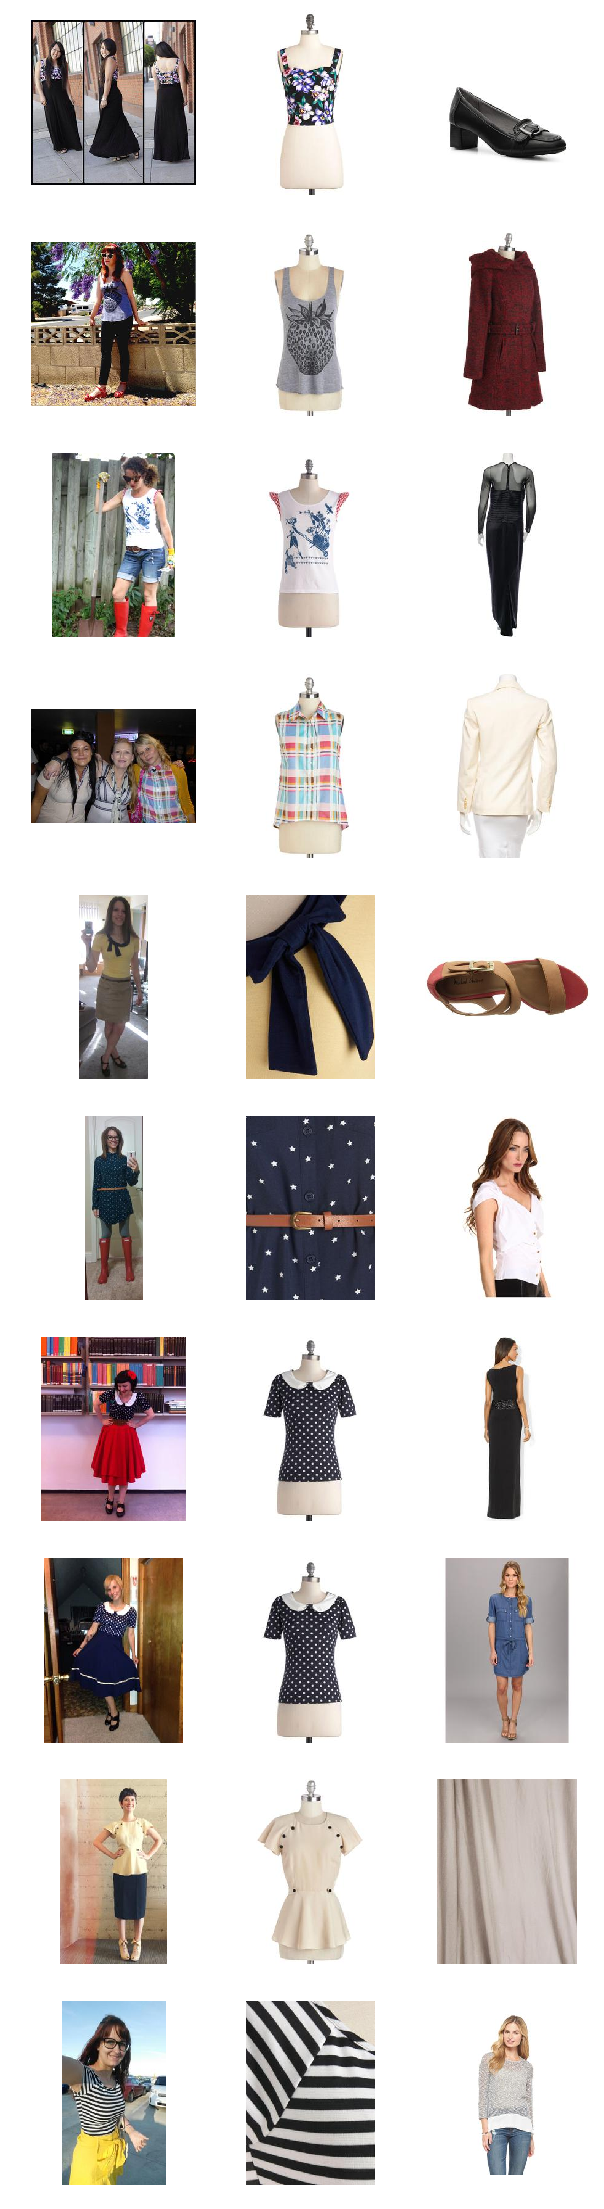

In [8]:
from random import shuffle
import random
import matplotlib.pyplot as plt
import cv2

fig=plt.figure(figsize=(10,40))
shuffle(db)
c=1

for triplet in db[:10]:
  triplet = triplet.split(",")
  for j in range(len(triplet)):
    im_q = cv2.imread("dataset/tops/{}".format(triplet[j]))
    im_q = cv2.cvtColor(im_q, cv2.COLOR_BGR2RGB)
    fig.add_subplot(10, 3, c)
    plt.axis('off')
    plt.imshow(im_q)
    c+=1

plt.axis('off')
plt.show()

#Configure

In [0]:
#@title Set Global Configs:  { run: "auto" }
#@markdown MILDNET_JOB_DIR (**mandatory**): Requires directory path to store training outputs. Either pass path of local directory or Google cloud storage (gs://.....)

MILDNET_JOB_DIR='output' #@param {type:"string"}
MILDNET_REGION=""
MILDNET_DATA_PATH=storage_path
#@markdown HYPERDASH_KEY (**optional**): Hyperdash key for live logging to mobile device.
HYPERDASH_KEY='' #@param {type:"string"}

with open("settings.cfg", "w") as f:
  f.write("MILDNET_JOB_DIR={}\nMILDNET_REGION={}\nMILDNET_DATA_PATH={}\nHYPERDASH_KEY={}"
          .format(MILDNET_JOB_DIR, MILDNET_REGION, MILDNET_DATA_PATH, HYPERDASH_KEY))

# print("Kindly tally the configs:")
# !cat settings.cfg

In [0]:
#@title Available Configs:
import glob

def bold_text(text):
  return "\033[1m {} \033[0m".format(text)

configs = {"Default Models:": glob.glob("job_configs/*.cnf")}
for path in glob.glob("job_configs/*/*.cnf"):
  conf_type = path.split("/")[-2].replace("_"," ").title()
  if conf_type in configs:
      configs[conf_type].append(path)
  else:
      configs[conf_type] = [path]

confs = {}
conf_types = list(configs.keys())
conf_types.sort()
for conf_type in conf_types:
  print(bold_text(conf_type))
  counter = 0
  for path in configs[conf_type]:
    counter+=1
    confs[str(len(confs)+1)] = path
    print("    {}: {}".format(counter, path.split("/")[-1]))

 Default Models: 
    1: alexnet.cnf
    2: ranknet.cnf
    3: vanila_vgg16.cnf
    4: visnet.cnf
    5: mildnet.cnf
    6: visnet-lrn2d.cnf
 Mildnet Ablation Study 
    1: mildnet_skip_3.cnf
    2: mildnet_skip_2.cnf
    3: mildnet_skip_4.cnf
    4: mildnet_skip_1.cnf
 Mildnet Low Features 
    1: mildnet_512_512.cnf
    2: mildnet_1024_512.cnf
    3: mildnet_512_no_dropout.cnf
 Mildnet Other Losses 
    1: mildnet_hinge_new.cnf
    2: mildnet_angular_2.cnf
    3: mildnet_contrastive.cnf
    4: mildnet_lossless.cnf
    5: mildnet_angular_1.cnf
 Mildnet Other Variants 
    1: mildnet_without_skip_big.cnf
    2: mildnet_vgg19.cnf
    3: mildnet_vgg16_big.cnf
    4: mildnet_without_skip.cnf
    5: mildnet_mobilenet.cnf
    6: mildnet_all_trainable.cnf
    7: mildnet_cropped.cnf


In [0]:
#@title Select a Config: { run: "auto" }
config = 'mildnet.cnf' #@param ['mildnet.cnf','ranknet.cnf','visnet.cnf','vanila_vgg16.cnf','visnet-lrn2d.cnf','alexnet.cnf','mildnet_ablation_study/mildnet_skip_1.cnf','mildnet_ablation_study/mildnet_skip_2.cnf','mildnet_ablation_study/mildnet_skip_3.cnf','mildnet_ablation_study/mildnet_skip_4.cnf','mildnet_low_features/mildnet_1024_512.cnf','mildnet_low_features/mildnet_512_512.cnf','mildnet_low_features/mildnet_512_no_dropout.cnf','mildnet_other_losses/mildnet_angular_1.cnf','mildnet_other_losses/mildnet_angular_2.cnf','mildnet_other_losses/mildnet_contrastive.cnf','mildnet_other_losses/mildnet_hinge_new.cnf','mildnet_other_losses/mildnet_lossless.cnf','mildnet_other_variants/mildnet_all_trainable.cnf','mildnet_other_variants/mildnet_cropped.cnf','mildnet_other_variants/mildnet_mobilenet.cnf','mildnet_other_variants/mildnet_vgg16_big.cnf','mildnet_other_variants/mildnet_vgg19.cnf','mildnet_other_variants/mildnet_without_skip.cnf','mildnet_other_variants/mildnet_without_skip_big.cnf']
import os
os.environ["MILDNET_CONFIG"] = "job_configs/{}".format(config)

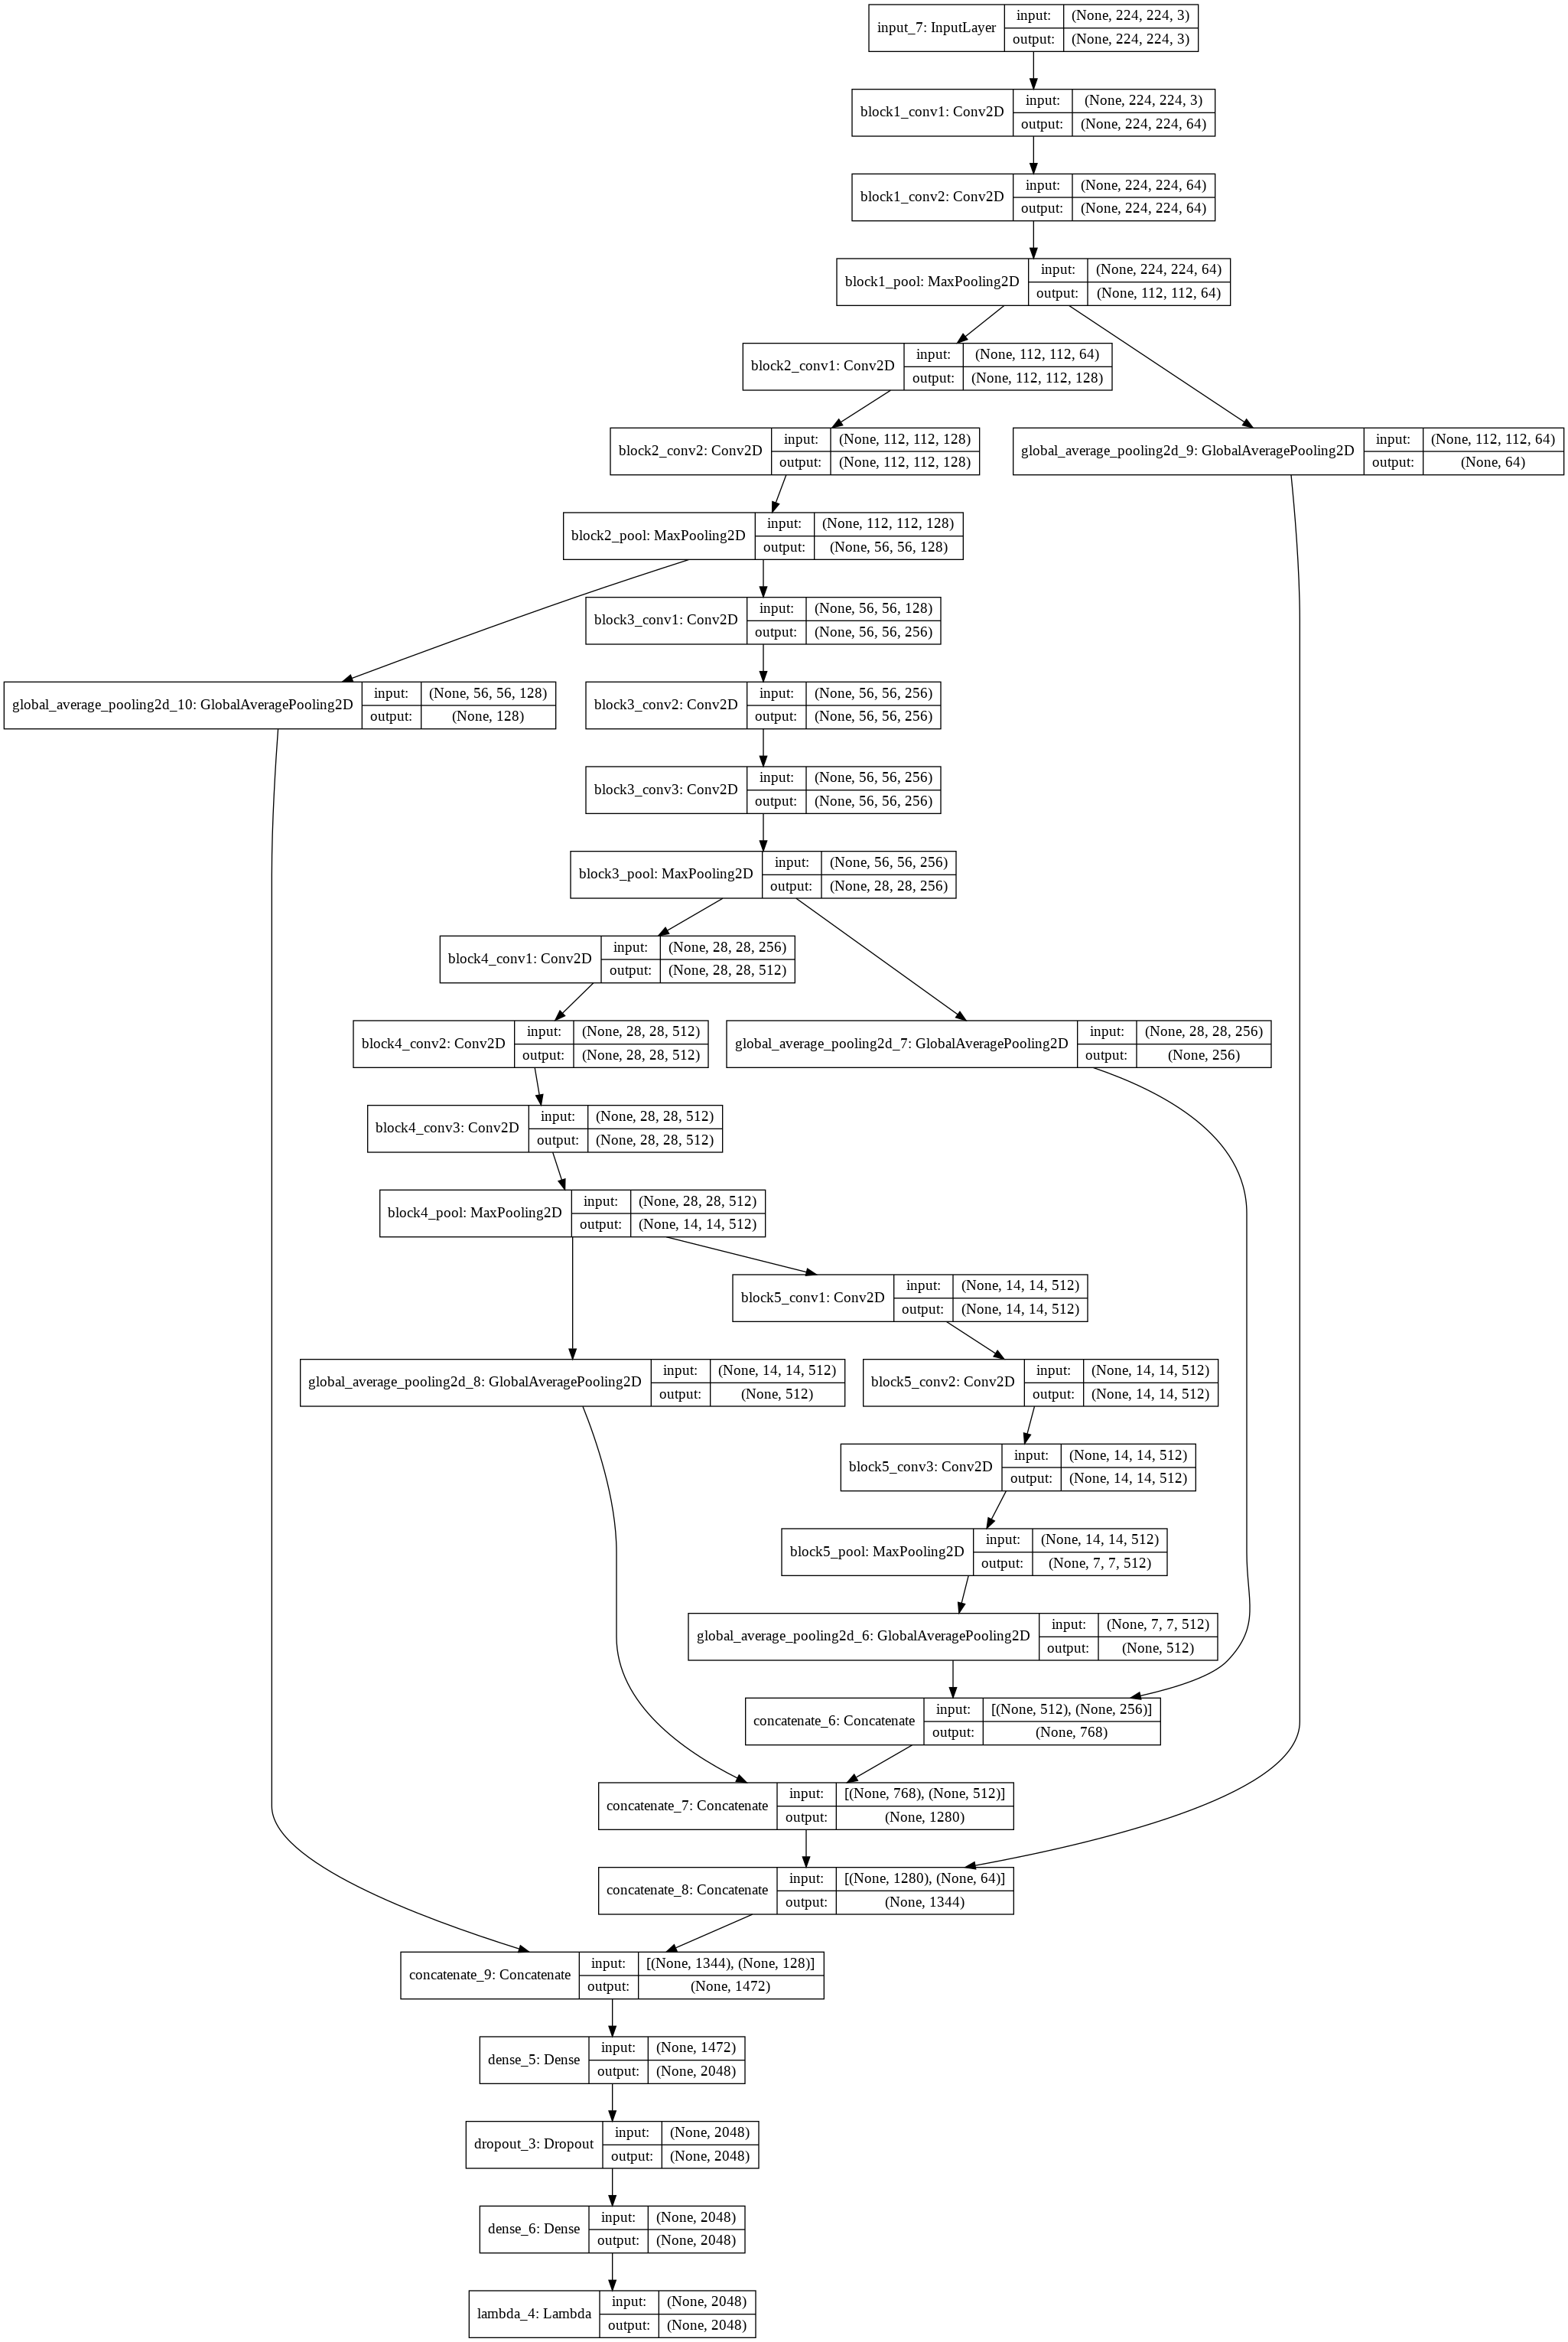

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

from trainer.model import *
with open("job_configs/"+config, "r") as f:
  for line in f.read().split("\n"):
    if "model_id=" in line:
      model_id = line.split('model_id=')[1].replace('"','')
    
if model_id in globals():
  model_getter = globals()[model_id]
  model = model_getter()
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
else:
  raise RuntimeError("Failed. Model function {} not found".format(model_id))
  
Image(retina=True, filename='model_plot.png')

#Start Training

In [0]:
!bash gcloud.local.run.keras.sh $MILDNET_CONFIG

job_configs/mildnet.cnf
INFO:root:Downloading Training Image from path gs://ml_shared_bucket/MILDNet/
INFO:root:Building Model: mildnet_vgg16
2019-03-07 07:12:44.184180: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-03-07 07:12:44.255522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-03-07 07:12:44.256021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 9.99GiB
2019-03-07 07:12:44.256060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1484] Adding visible gpu devices: 0
2019-03-07 07:12:44.599244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:965] Device interconnect

# Results

The code published the results at gcloud storage path set on the global config param MILDNET_JOB_DIR. Besides this all the output can also be found in the "output" folder.
- Training logs are stored in "training.log file"
- Model details are stored in "model.def", "model_code.pkl", "model_code.txt" files
- Model weights where improvements in validation accuracy is observed is stored in format weights-improvement-{{epoch_number}}-{{validation_loss}}.h5

# Inference

In [0]:
from tensorflow.keras.models import model_from_json

print("Loading model from model.def file\n")
json_file = open("output/model.def", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

weights = glob.glob("output/weights-improvement-*")
weights.sort()
print("Loading weights from top performing epoch: {}\n".format(weights[-1]))
model.load_weights(weights[-1])

img_size = int(model.input.shape[1])
print("The model accepts input of size: [{},{},3]".format(img_size, img_size))

Loading model from model.def file

Loading weights from top performing epoch: output/weights-improvement-01-0.40.h5

The model accepts input of size: [224,224,3]


In [0]:
import numpy as np
import keras.backend as K

def preprocess_img(image):
  p_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (img_size, img_size))
  p_image = np.expand_dims(p_image, axis=0)
  return p_image

def get_pred(model, image):
  if model.input_shape[0]:
    op_quer = model.predict([image,image,image])
  else:
    op_quer = model.predict(image)
  return op_quer

def load_image_and_preprocess(image):
  image = cv2.imread('dataset/tops/{}'.format(image))
  image = preprocess_img(image)
  return image

def test_triplet(model):
  with open("tops_val_full.csv", "r") as file:
    triplets = file.read().split("\n")
    
    triplet = triplets[0]
    q, p, n = triplet.split(",")
    
    q, p, n = load_image_and_preprocess(q), load_image_and_preprocess(p), load_image_and_preprocess(n)
    
    batch_x = np.zeros((3, 224, 224, 3), dtype=K.floatx())
    batch_x[:] = [q, p, n]
    
    pred_q, pred_p, pred_n = get_pred(model, batch_x)
    
    D_q_p = np.sqrt(np.sum(np.square(pred_q - pred_p)))
    D_q_n = np.sqrt(np.sum(np.square(pred_q - pred_n)))
    
    print("Distance b/w query and positive image: {}\nDistance b/w query and negative image: {}\n\nModel performed {}"
          .format(D_q_p,D_q_n,"correctly" if D_q_p<D_q_n else "incorrectly"))
    
test_triplet(model)

Distance b/w query and positive image: 0.203023552895
Distance b/w query and negative image: 0.217806831002

Model performed correctly
